# Analysing Smartphone Prices

In [63]:
from statistics import stdev, median

import requests
from urllib import parse
import re

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## 1. Loading Devices Names

In [2]:
RELATIVE_PATH_TO_DATA_FOLDER = './data/'
filename = 'devices_using_ribonapp_data'
filename_with_path = RELATIVE_PATH_TO_DATA_FOLDER + filename + '.csv'
devices_df = pd.read_csv(filename_with_path, skiprows=1, names=['model_name', 'old_price_range'])
devices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   model_name       1129 non-null   object
 1   old_price_range  1129 non-null   object
dtypes: object(2)
memory usage: 17.8+ KB


### Cleaning Duplicates and Missing Values

In [4]:
devices_df.drop_duplicates(['model_name'], inplace=True)
devices_df.dropna(axis=0, inplace=True)
devices_df

,model_name,old_price_range
0,2 A2005,Low
1,3,Low
2,3T,Low
3,4047D,Low
4,5,Low
...,...,...
1124,nova 4,Low
1125,t1_8p0lte,Low
1126,vivo 1724,Low
1127,vivo X9,Low


### Filtering Non Informative Names

In [5]:
informative_names_mask = devices_df['model_name'].str.len() > 1
devices_df = devices_df[informative_names_mask]
devices_df

,model_name,old_price_range
0,2 A2005,Low
2,3T,Low
3,4047D,Low
5,5051J,Low
6,5056D,Low
...,...,...
1124,nova 4,Low
1125,t1_8p0lte,Low
1126,vivo 1724,Low
1127,vivo X9,Low


# Searching for Prices

In [6]:
url_base = "https://celulares.mercadolivre.com.br/"
item_list = devices_df['model_name'].to_list()

# TODO ADD OPTION TO SEARCH ONLY NEW PRODUCTS 
# title="Novo" href="(.*?)">
url_list = [url_base + parse.quote(item_name) for item_name in item_list]
found_search_contents = []
item_count = 1
for url, item_original_name in zip(url_list, item_list):
    print(item_count)
    item_count += 1
    r = requests.get(url)
    text_content = str(r.text)
    # Let's filter the are to search for only search results

    result_field_text_content = re.search(r'<ol id="searchResults"(.+?)<\/ol>', text_content)
    if result_field_text_content:
        result_field_text_content = result_field_text_content.groups()[0]
    else:
        result_field_text_content = None
    found_search_contents.append([item_original_name, url, result_field_text_content])

extracted_data_df = pd.DataFrame(data=found_search_contents, columns=['item_original_name','url', 'page_search_content'])
extracted_data_df

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,item_original_name,url,page_search_content
0,2 A2005,https://celulares.mercadolivre.com.br/2%20A2005,None
1,3T,https://celulares.mercadolivre.com.br/3T,"class=""section search-results list-view stack..."
2,4047D,https://celulares.mercadolivre.com.br/4047D,None
3,5051J,https://celulares.mercadolivre.com.br/5051J,"class=""section search-results list-view stack..."
4,5056D,https://celulares.mercadolivre.com.br/5056D,None
...,...,...,...
1118,nova 4,https://celulares.mercadolivre.com.br/nova%204,"class=""section search-results list-view stack..."
1119,t1_8p0lte,https://celulares.mercadolivre.com.br/t1_8p0lte,"class=""section search-results list-view stack..."
1120,vivo 1724,https://celulares.mercadolivre.com.br/vivo%201724,"class=""section search-results list-view stack..."
1121,vivo X9,https://celulares.mercadolivre.com.br/vivo%20X9,"class=""section search-results list-view stack..."


## Storing Raw Price Information

In [6]:
extracted_filename = 'device_search_results'
extracted_filename_with_path = RELATIVE_PATH_TO_DATA_FOLDER + extracted_filename + '.csv'

In [8]:
extracted_data_df.to_csv(extracted_filename_with_path, index=False)

## Treating Data

In [7]:
device_raw_extracted_data_df = pd.read_csv(extracted_filename_with_path, header=0)
device_raw_extracted_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1123 entries, 0 to 1122
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   item_original_name   1123 non-null   object
 1   url                  1123 non-null   object
 2   page_search_content  893 non-null    object
dtypes: object(3)
memory usage: 26.4+ KB


In [8]:
%time
device_raw_extracted_data_df.dropna(axis=0, inplace=True)
device_raw_extracted_data_df

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


,item_original_name,url,page_search_content
1,3T,https://celulares.mercadolivre.com.br/3T,"class=""section search-results list-view stack..."
3,5051J,https://celulares.mercadolivre.com.br/5051J,"class=""section search-results list-view stack..."
6,5T,https://celulares.mercadolivre.com.br/5T,"class=""section search-results list-view stack..."
7,6039J,https://celulares.mercadolivre.com.br/6039J,"class=""section search-results list-view stack..."
9,6055B,https://celulares.mercadolivre.com.br/6055B,"class=""section search-results list-view stack..."
...,...,...,...
1118,nova 4,https://celulares.mercadolivre.com.br/nova%204,"class=""section search-results list-view stack..."
1119,t1_8p0lte,https://celulares.mercadolivre.com.br/t1_8p0lte,"class=""section search-results list-view stack..."
1120,vivo 1724,https://celulares.mercadolivre.com.br/vivo%201724,"class=""section search-results list-view stack..."
1121,vivo X9,https://celulares.mercadolivre.com.br/vivo%20X9,"class=""section search-results list-view stack..."


In [80]:
INVALID_WORDS = set(['DEFEITO', 'TROCO', 'QUEBRADO', 'CABO', 'CONECTOR', 'PEÇA'])
pages_contents = device_raw_extracted_data_df
number_of_items_to_count = 10
item_names_and_prices = []
for i, device_row in device_raw_extracted_data_df.iterrows():
    page_content = device_row['page_search_content']
    item_original_name = device_row['item_original_name']
    
    raw_names_and_prices = re.findall(r'"main-title">(.+?)<\/span>[\s\S]*?"price__fraction">([\d\.]+?)<\/span>', page_content)

    valid_prices = []
    choosen_name = None
    for item_raw_name, item_raw_price in raw_names_and_prices:
        found_name = item_raw_name.upper()
        if not INVALID_WORDS in set(found_name) or item_original_name.upper() in found_name:
            if not choosen_name:
                choosen_name = found_name
            item_price = None
            if '.' in item_raw_price:
                # In this case there are more than one dot symbol
                item_price = 0
                raw_price_numbers_list = item_raw_price.split('.')
                for i, number in enumerate(raw_price_numbers_list):
                    item_price += int(number)*10**((len(raw_price_numbers_list)-i-1)*3)
                item_price = int(item_price)
            else:
                item_price = int(item_raw_price)
            valid_prices.append(item_price)

    if valid_prices:
        item_price = int(median(valid_prices))
    else:
        item_price = None

    item_names_and_prices.append([item_original_name, choosen_name, item_price])
print(len(item_names_and_prices))


893


In [82]:
extracted_data_df = pd.DataFrame(data=item_names_and_prices, columns=['item_original_name','item_extracted_name', 'item_price'])
print(extracted_data_df.info())
extracted_data_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   item_original_name   893 non-null    object
 1   item_extracted_name  893 non-null    object
 2   item_price           893 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.1+ KB
None


,item_original_name,item_extracted_name,item_price
0,3T,CELULAR ONEPLUS 3T DUAL A3010 4G 64GB 5.5 16M...,2250
1,5051J,PLACA 2CHIP DO CELULAR ALCATEL MODELO 5051J. ...,140
2,5T,HUAWEI NOVA SERIES NOVA 5T DUAL SIM 128 GB BL...,2679
3,6039J,ALCATEL 6039J CINZA,70
4,6055B,SMARTPHONE ALCATEL IDOL 4 6055B 16GB 3GB RAM ...,599
...,...,...,...
888,nova 4,SAMSUNG GALAXY J2 CORE DUAL SIM 16 GB PRATA (...,1574
889,t1_8p0lte,CELULAR MOTOROLA 60T NÃO É NEM USA CHIP. ENVI...,300
890,vivo 1724,LG K SERIES K10 NOVO DUAL SIM 32 GB PRETO 2 G...,159
891,vivo X9,LG K SERIES K10 NOVO DUAL SIM 32 GB PRETO 2 G...,187


##  Storing Results

In [84]:
extracted_filename = 'extracted_device_data_2'
extracted_filename_with_path = RELATIVE_PATH_TO_DATA_FOLDER + extracted_filename + '.csv'

In [85]:
extracted_data_df.to_csv(extracted_filename_with_path, index=False)

#  Analysing Prices

In [86]:
device_extracted_data_df = pd.read_csv(extracted_filename_with_path, header=0)
device_extracted_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   item_original_name   893 non-null    object
 1   item_extracted_name  893 non-null    object
 2   item_price           893 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.1+ KB


## Prices Distribution

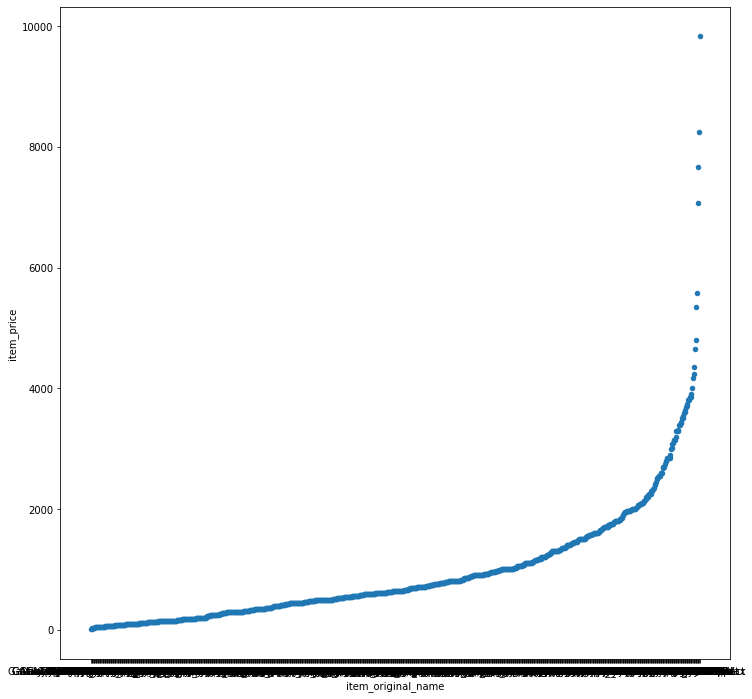

In [87]:
device_extracted_data_df.sort_values(by='item_price', inplace=True)
device_extracted_data_df.plot.scatter(x=0, y='item_price', figsize=(12, 12))

## Prices Binning

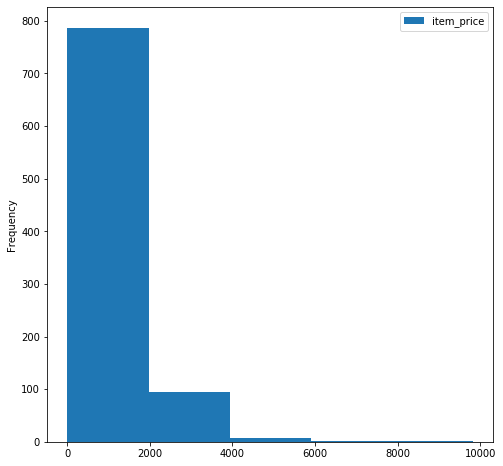

In [88]:
device_extracted_data_df.describe()
device_extracted_data_df.plot.hist(by=['item_price'], bins=5, figsize=(8, 8))


# Price  Ranges
![Brazilian IBGE Salaries Ranges Research](./assets/ibge_brazilian_salary_ranges.jpg)

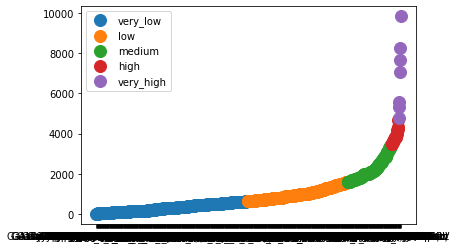

In [89]:
ibge_price_ranges_labels = ['very_low', 'low', 'medium', 'high', 'very_high']
salaries_ibge_ranges = [(0, 1908), (1909, 2862), (2863, 5724), (5725, 3566)]
ibge_price_ranges = [0]
for i, salarie_range in enumerate(salaries_ibge_ranges):
    threshold_price = (salarie_range[0] + salarie_range[1])//3
    # As the values are so low, we have to increment them with the previous threshold
    threshold_price += ibge_price_ranges[i-1]
    ibge_price_ranges.append(threshold_price)
ibge_price_ranges.append(float('inf'))

device_extracted_data_df['ibge_price_range'] = pd.cut(device_extracted_data_df['item_price'], bins=ibge_price_ranges, labels=ibge_price_ranges_labels)
groups = device_extracted_data_df.groupby('ibge_price_range', sort=False)
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['item_original_name'], group['item_price'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [90]:
device_extracted_data_df

,item_original_name,item_extracted_name,item_price,ibge_price_range
64,Breeze 7Y2241,CONECTOR MICRO USB TABLET AOC BREEZE AOC 7 7Y...,6,very_low
555,P2,CELULAR DL YC330 ACOMPANHA FONE P2 C/ MICROFO...,19,very_low
691,U20_Plus,CELULAR SONY ERICSSON XPERIA X10 MINI ORIGINA...,24,very_low
737,Xperia M2 D2303,SONY M2 D2303 D2305 D2306 PEÇAS,25,very_low
471,Motion Plus Sk351,CELULAR CCE SK351 SUCATA P/ RETIRADA DE PEÇAS...,30,very_low
...,...,...,...,...
70,Cat S61,CAT S61 64 GB PRETO/PRATA 4 GB RAM,5578,very_high
459,Max 4 Pro,APPLE IPHONE 11 PRO MAX DUAL SIM 64 GB CINZA-...,7074,very_high
843,iPhone 11 Pro,APPLE IPHONE 11 PRO MAX DUAL SIM 64 GB CINZA-...,7669,very_high
844,iPhone 11 Pro Max,APPLE IPHONE 11 PRO MAX DUAL SIM 64 GB CINZA-...,8250,very_high


## Comparing with old price ranges

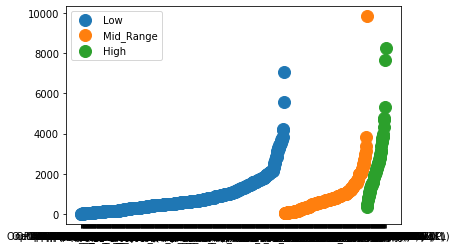

In [91]:
device_extracted_data_df = device_extracted_data_df.merge(right=devices_df, left_on='item_original_name', right_on='model_name', how='inner').drop(columns='model_name')
groups = device_extracted_data_df.groupby('old_price_range', sort=False)
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['item_original_name'], group['item_price'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()